In [1]:

import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.cm as cmx

/user/sebert/home/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib64/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def calc_taunn(krel,krec,bet):

     return 1/(krec+krel*bet)

# load data

In [3]:


# filepath = sys.argv[1]
stim_type = 'smooth'
# param = sys.argv[3]
# val = sys.argv[4]
# par = f'{param}_{val}'

net = 'Reciporcal_mono_linear_heavy_maxan_equalweight/noGCGainControl'

# load dataframe 
response_data = pd.read_csv(f'/user/sebert/home/Documents/Simulations/motion/anticipation_1D/Reciporcal/{net}/responses_RG_nAB_wBAfixed_long.csv')


# load dataframe 
df = pd.read_csv(f'/user/sebert/home/Documents/Simulations/motion/anticipation_1D/Reciporcal/{net}/anticipation_data_nAB_wBAfixed_long.csv')


print(df.columns)

# calculate anticipation with respect to V_drive
df['ant_RG_drive_time']  =  df['peak_drive'] - df['peak_RG'] 
df['ant_RG_drive_space'] = df['ant_RG_drive_time']* df['speed']

# calculate anticipation with respect to 
df['ant_RG_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RG'] 
df['ant_RG_bar_space'] = df['ant_RG_bar_time']* df['speed']


df['taunB'] = calc_taunn(0.1,0.1,df['betaB'])
df['taunAr']= df['taunA'].round(3)
df['taunBr']= df['taunB'].round(3)
# multiple heatmaps, keeping w+ fixed and changing w-
#dfgrouped = df.groupby(['wAB'])


speeds = df['speed'].unique()#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0]


Index(['Unnamed: 0', 'wBA', 'wAB', 'tauA', 'tauB', 'speed', 'peak_RG',
       'peak_RB', 'peak_drive', 'tp_rf_GC_mid', 'peak_RG_pooling',
       'peak_RB_pooling', 'onset_RB', 'onset_RG', 'betaA', 'betaB', 'krecA',
       'krecB', 'krelA', 'krelB', 'neqA', 'neqB', 'nminA', 'nminB',
       'onset_RB_pooling', 'onset_RG_pooling', 'taunA', 'taunB'],
      dtype='object')


In [4]:
#winning values
betaB = 0.6
betaA = 0.03

plastic = df.query(f'betaA == {betaA} and betaB == {betaB}')

In [5]:
# load example network with and without plasticity

data = {}
cell = 150

nets_list = ['Reciporcal_mono_linear_plastic_opt/noGCGainControl/betaA/betaA_0.04',
             'Reciporcal_mono_linear_plastic_opt/noGCGainControl/only_one_plasticity/betaB/betaB_0.0',
             'Reciporcal_mono_linear_plastic_opt/noGCGainControl/only_one_plasticity/betaB/betaB_0.6',
             'Reciporcal_mono_linear_plastic_opt/noGCGainControl/only_one_plasticity/betaA/betaA_0.04']

for net in nets_list:
    
    data[net] = {}

    bars = []
    tps_rf_GC_mid = []
    times = []

    Fs = []
    RBs = []
    RAs = []
    RGs = []
    OBs = []
    OAs = []

    peaks_RG = []
    peaks_RB = []
    peaks_drive = []

    amps_RB = []
    amps_RA = []
    amps_RG = []
    amps_drive = []

    ants_RB_drive = []
    ants_RB_bar = []

    ants_RG_drive = []
    ants_RG_bar = []

    omins_B = []
    omins_A = []

    for s in speeds: 
        fp = f'/user/sebert/home/Documents/Simulations/motion/anticipation_1D/Reciporcal/{net}/smooth_{s}'
        with open(f'{fp}/out', 'rb') as handle:
            out = pickle.load(handle)    
            
        with open(f'{fp}/params', 'rb') as handle:
            paramsi = pickle.load(handle)
            
        duration = paramsi['duration']
        dt = paramsi['dt']
        time = np.arange(0,duration,dt) #- (paramsi['spacing']*cell)/paramsi['speed']#*1000#+45
        pos_cell = paramsi['pos_rf_GC_mid'][cell]
        #barr = [bar(t,pos_cell, v = s) for t in time]
        tp_bar = paramsi['tps_rf_GC_mid'][cell]

        peak_RB = time[np.argmax(out['RB'][50,:])]
        peak_RG = time[np.argmax(out['RG'][:])]
        peak_drive = time[np.argmax(out['F'][:])]

        amp_RB = np.max(out['RB'][50,:])
        amp_RA = np.max(out['RA'][50,:])
        amp_RG = np.max(out['RG'][:])
        amp_drive = np.max(out['F'][:])

        omin_B = np.min(out['OB'][50,:])
        omin_A = np.min(out['OA'][50,:])


        # RAM
        ant_RB_drive =  peak_drive - peak_RB
        ant_RB_bar  =  tp_bar - peak_RB

        ant_RG_drive =  peak_drive - peak_RG
        ant_RG_bar =  tp_bar - peak_RG

        #bars.append(barr)
        tps_rf_GC_mid.append(tp_bar)
        times.append(time)

        Fs.append(out['F'])
        RBs.append(out['RB'][50,:])
        RAs.append(out['RA'][50,:])
        RGs.append(out['RG'])
        OBs.append(out['OB'][50,:])
        OAs.append(out['OA'][50,:])

        peaks_RB.append(peak_RB)
        peaks_RG.append(peak_RG)
        peaks_drive.append(peak_drive)

        amps_RB.append(amp_RB)
        amps_RA.append(amp_RA)
        amps_RG.append(amp_RG)
        amps_drive.append(amp_drive)

        ants_RB_drive.append(ant_RB_drive)
        ants_RB_bar.append(ant_RB_bar)
        
        ants_RG_drive.append(ant_RG_drive)
        ants_RG_bar.append(ant_RG_bar)

        omins_B.append(omin_B)
        omins_A.append(omin_A)

        # get amplitudes 


    data[net]['peaks']={}
    data[net]['peaks']['RB'] = np.asarray(peaks_RB)
    data[net]['peaks']['RG'] = np.asarray(peaks_RG)
    data[net]['peaks']['drive'] =np.asarray( peaks_drive)

    data[net]['amps']={}
    data[net]['amps']['RB'] = np.asarray(amps_RB)
    data[net]['amps']['RA'] = np.asarray(amps_RA)
    data[net]['amps']['RG'] = np.asarray(amps_RG)
    data[net]['amps']['drive'] =np.asarray( amps_drive)
    
    data[net]['omin'] = {}
    data[net]['omin']['B'] = np.asarray(omins_B)
    data[net]['omin']['A'] = np.asarray(omins_A)

    data[net]['ants'] ={}
    data[net]['ants']['RB_drive'] =np.asarray(ants_RB_drive)
    data[net]['ants']['RB_bar'] =np.asarray(ants_RB_bar)
    data[net]['ants']['RG_drive'] =np.asarray(ants_RG_drive)
    data[net]['ants']['RG_bar'] =np.asarray(ants_RG_bar)
    
    data[net]['RB'] = RBs
    data[net]['RA'] = RAs
    data[net]['RG'] = RGs
    data[net]['F'] = Fs
    data[net]['OB'] = OBs
    data[net]['OA'] = OAs

    data['bars'] = bars
    data['tps_rf_mid'] = np.asarray(tps_rf_GC_mid)
    data['times'] = times


net_plastic = nets_list[0]
net_fixed = nets_list[1]
net_plasticB = nets_list[2]
net_plasticA = nets_list[3]

# Figure Parameter

In [6]:
fontsize_legend = 20
fontsize_labels = 15
fontsize_panellabel = 30
fontsize_ticks = 20
lw = 4
ms = 60

figsize_ratio = 3
figsize = (16,8)

save = True
save_name = "Figure 1"
show = True
image_format = "png"
dpi = 300
panellabel_position = [-0.14, .75]


In [7]:
speeds_plot = [0.1,0.5,1.0]
speeds_plot_idx = [0,4,-2]
xlims = [(2,12),(1.2,3),(0.2,0.75)]

In [8]:
%matplotlib qt

ModuleNotFoundError: No module named 'matplotlib.backends.backend_qt5agg'

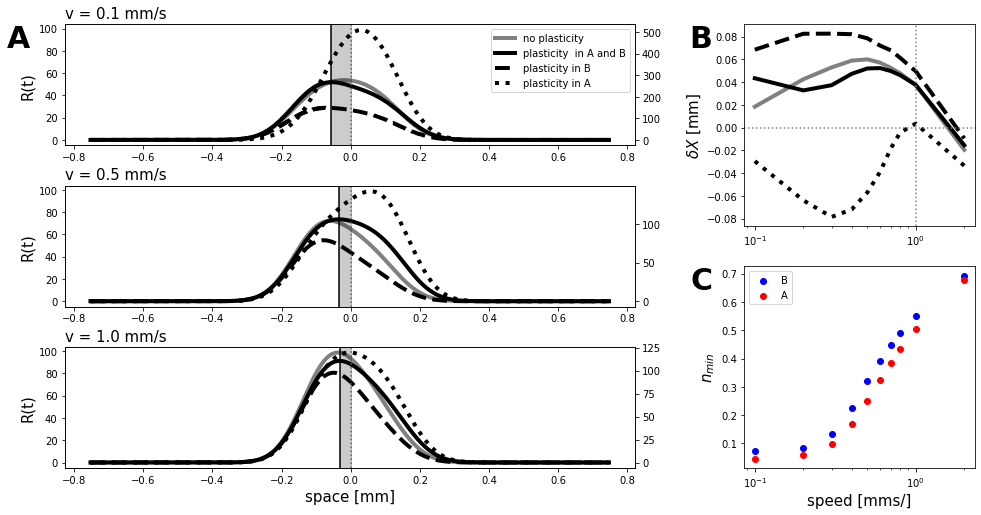

In [9]:
c = 'k'
cbar = 'grey'

#initialize figure
nrows = 6
ncols = 3

fig = plt.figure(figsize=figsize)
#fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')


gs = fig.add_gridspec(nrows,ncols)
#fig.tight_layout()


#TODO adjustment
fig.subplots_adjust(top=0.88,
bottom=0.11,
left=0.11,
right=0.9,
hspace=1.0,
wspace=0.475)


#TODO remove axis

#TODO fontsizes


cbar = 'grey'
c1 = 'k'

for x,s in enumerate(speeds_plot):
    i = speeds_plot_idx[x]
    #title

    if i == 0:
        ax = fig.add_subplot(gs[2*x:2*x+2,0:2])
        ax2 = ax.twinx()
        ax.text(panellabel_position[0]+0.08,panellabel_position[1]+0.25, "A", transform=ax.transAxes,
       fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')
    else:
        ax = fig.add_subplot(gs[2*x:2*x+2,0:2], sharey = ax)
        ax2 = ax.twinx()
        
    ax.set_title(f'v = {s} mm/s', loc = 'left', fontsize = fontsize_labels)

    xdata =(data['times'][i]- data['tps_rf_mid'][i])*s 

    ax.plot(xdata, data[net_fixed]['RG'][i], color = 'grey', linewidth = lw, linestyle = '-', label = 'no plasticity')
    ax.plot(xdata, data[net_plastic]['RG'][i], color = c, linestyle = '-', label = 'plasticity  in A and B', linewidth =lw)
    ax.plot(xdata, data[net_plasticB]['RG'][i], color = c,linestyle = '--', label = 'plasticity in B', linewidth = lw)
    ax2.plot(xdata, data[net_plasticA]['RG'][i], color = c, linestyle = ':', label = 'plasticity in A', linewidth = lw)


    t_fixed = data[net_fixed]['peaks']['RG'][i]*s  - data['tps_rf_mid'][i]*s
    t_plastic = data[net_plastic]['peaks']['RG'][i]*s  - data['tps_rf_mid'][i]*s
    #ax2.axvline(t_fixed , color = c2, linestyle = ':')
    ax2.axvline(t_plastic, color = c)
    ax2.axvspan(0,t_plastic, color = c, alpha =0.2)


    ax.axvline(0, color = cbar, linestyle = ':')

    if x ==0:

        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc=0)
    ax.set_ylabel('R(t)', fontsize = fontsize_labels)
    if x == 2:
        ax.set_xlabel('space [mm]', fontsize = fontsize_labels)


ax = fig.add_subplot(gs[0:3,2])
ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "B", transform=ax.transAxes,
       fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')
# ax.plot(speeds, data[net_fixed]['ants']['RG_bar']*speeds,  color = 'grey', linewidth = 5, linestyle = '-', label = 'no plasticity')
# ax.plot(speeds, data[net_plastic]['ants']['RG_bar']*speeds,  color = 'blue', linestyle = '-', label = 'plasticity  in A and B')
# ax.plot(speeds, data[net_plasticB]['ants']['RG_bar']*speeds, color = 'blue',linestyle = '--', label = 'plasticity in B')
# ax.plot(speeds, data[net_plasticA]['ants']['RG_bar']*speeds, color = 'blue', linestyle = ':', label = 'plasticity in A')


ax.plot(speeds, data[net_fixed]['ants']['RG_bar']*speeds,  color = 'grey', linewidth = lw, linestyle = '-', label = 'no plasticity')
ax.plot(plastic['speed'], plastic['ant_RG_bar_space'],  color = c, linestyle = '-', label = 'plasticity  in A and B', linewidth = lw)
# ax.plot(plastic2['speed'], plastic2['ant_RG_bar_space'], linestyle = '-', label = 'plasticity  in A and B')
# ax.plot(plastic3['speed'], plastic3['ant_RG_bar_space'],   linestyle = '-', label = 'plasticity  in A and B')
ax.plot(speeds, data[net_plasticB]['ants']['RG_bar']*speeds, color = c,linestyle = '--', label = 'plasticity in B', linewidth = lw)
ax.plot(speeds, data[net_plasticA]['ants']['RG_bar']*speeds, color = c, linestyle = ':', label = 'plasticity in A', linewidth = lw)

ax.axhline(0,color = cbar, linestyle = ':')
ax.axvline(1,color = cbar, linestyle = ':')
ax.set_xscale('log')
#ax.set_xlabel('speed [mms]')
ax.set_ylabel('$\delta X$ [mm]', fontsize = fontsize_labels)
#ax.legend()


ax = fig.add_subplot(gs[3:,2])
ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "C", transform=ax.transAxes,
       fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')
ax.scatter(speeds, data[net_plastic]['omin']['B'], label = 'B', color = 'blue')
ax.scatter(speeds, data[net_plastic]['omin']['A'], label = 'A', color = 'red')
ax.set_xscale('log')
ax.set_xlabel('speed [mms/]', fontsize = fontsize_labels)
ax.set_ylabel('$n_{min}$', fontsize = fontsize_labels)
ax.legend()

In [10]:
c0 = 'blue'
c1 = 'red'
c2 = 'green'
cbar = 'grey'
#initialize figure
nrows = 27
ncols = 6

fig = plt.figure(figsize=figsize)
#fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')


gs = fig.add_gridspec(nrows,ncols)
#fig.tight_layout()


#TODO adjustment
fig.subplots_adjust(top=0.88,
bottom=0.11,
left=0.11,
right=0.9,
hspace=0.77,
wspace=0.475)


#TODO remove axis

#TODO fontsizes



#weights = [0.0,10.0,50.0,100.0]


for x,s in enumerate(speeds_plot):
    i = speeds_plot_idx[x]
    #title
    if i == 0:
        ax = fig.add_subplot(gs[0:4,2*x:2*x+2])
        ax1 = fig.add_subplot(gs[4:8,2*x:2*x+2])
        ax2 = fig.add_subplot(gs[8:12,2*x:2*x+2])
    else:
        ax = fig.add_subplot(gs[0:4,2*x:2*x+2], sharey = ax)
        ax1 = fig.add_subplot(gs[4:8,2*x:2*x+2], sharey = ax1)
        ax2 = fig.add_subplot(gs[8:12,2*x:2*x+2], sharey = ax2)
      
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    xdata =(data['times'][i]- data['tps_rf_mid'][i])*s 

    #ax.plot(xdata,data['bars'][i], label = f'bar', color = cbar)

        
    ax.plot(xdata,data[net_fixed]['RB'][i], color = 'blue', linestyle = ':', label = 'R_{B} fixed' )
    ax.plot(xdata,data[net_plastic]['RB'][i], color = 'blue', label = 'R_{B}  plastic')

    ax1.plot(xdata,data[net_fixed]['RA'][i], color = c1, linestyle = ':', label = 'R_{A} fixed' )
    ax1.plot(xdata,data[net_plastic]['RA'][i], color = c1, label = 'R_{A}  plastic')

    # ax.plot(data['times'][0],data[net_fixed]['RA'][0], color = 'red', linestyle = ':', label = 'fixed' )
    # ax.plot(data['times'][0],data[net_plastic]['RA'][0], color = 'red', label = 'plastic')

    ax2.plot(xdata,data[net_fixed]['RG'][i], color = c2, linestyle = ':', label = 'R_{G} fixed' )
    ax2.plot(xdata,data[net_plastic]['RG'][i], color = c2, label = 'R_{G} plastic')


    ax.set_ylabel('R(t)')
    ax2.set_ylabel('R(t)')
    if 
    ax2.set_xlabel('space [mm]')

    # ax.axvline(0, color = cbar, linestyle = ':')
    # ax2.axvline(0, color = cbar, linestyle = ':')

    t_fixed = data[net_fixed]['peaks']['RB'][i]*s  - data['tps_rf_mid'][i]*s
    t_plastic = data[net_plastic]['peaks']['RB'][i]*s  - data['tps_rf_mid'][i]*s
    ax.axvline(t_fixed , color = c0, linestyle = ':')
    ax.axvline(t_plastic, color = c0)
    ax.axvspan(t_fixed,t_plastic, color = c0, alpha =0.2)
    
    # t_fixed = data[net_fixed]['peaks']['RA'][i]*s  - data['tps_rf_mid'][i]*s
    # t_plastic = data[net_plastic]['peaks']['RA'][i]*s  - data['tps_rf_mid'][i]*s
    # ax1.axvline(t_fixed , color = c1, linestyle = ':')
    # ax1.axvline(t_plastic, color = c1)
    # ax1.axvspan(t_fixed,t_plastic, color = c1, alpha =0.2)

    t_fixed = data[net_fixed]['peaks']['RG'][i]*s  - data['tps_rf_mid'][i]*s
    t_plastic = data[net_plastic]['peaks']['RG'][i]*s  - data['tps_rf_mid'][i]*s
    ax2.axvline(t_fixed , color = c2, linestyle = ':')
    ax2.axvline(t_plastic, color = c2)
    ax2.axvspan(t_fixed,t_plastic, color = c2, alpha =0.2)

    if x == 0:
        ax.legend()
        ax2.legend()




ax = fig.add_subplot(gs[15:,:2])
for i,s in enumerate(speeds):
    ax.plot(data['times'][i]*s,data[net_plastic]['OA'][i], label = f'v = {s}')

ax.legend()
ax.set_xlabel('time [s]')
ax.set_ylabel('n(t)')



ax = fig.add_subplot(gs[15:,4:])

ax.scatter(speeds, data[net_fixed]['ants']['RG_bar']*speeds, color = c2, marker = '*', label = 'R_{G} fixed')
ax.scatter(speeds, data[net_plastic]['ants']['RG_bar']*speeds, marker = 'v',color = c2, label = 'R_{G} plastic')
ax.legend()
ax.axhline(0,color = cbar, linestyle = ':')
ax.set_xlabel('speed [ mm/s]')
ax.set_ylabel('$\delta X$ [mm]')





ax = fig.add_subplot(gs[15:,2:4])

ax.plot(speeds, data[net_fixed]['ants']['RG_bar']*speeds,  color = 'grey', linewidth = 5, linestyle = '-', label = 'no plasticity')
ax.plot(plastic['speed'], plastic['ant_RG_bar_space'],  color = 'green', linestyle = '-', label = 'plasticity  in A and B')
# ax.plot(plastic2['speed'], plastic2['ant_RG_bar_space'], linestyle = '-', label = 'plasticity  in A and B')
# ax.plot(plastic3['speed'], plastic3['ant_RG_bar_space'],   linestyle = '-', label = 'plasticity  in A and B')
ax.plot(speeds, data[net_plasticB]['ants']['RG_bar']*speeds, color = 'green',linestyle = '--', label = 'plasticity in B')
ax.plot(speeds, data[net_plasticA]['ants']['RG_bar']*speeds, color = 'green', linestyle = ':', label = 'plasticity in A')

ax.axhline(0,color = cbar, linestyle = ':')
ax.axvline(1,color = cbar, linestyle = ':')
ax.set_xscale('log')
ax.set_xlabel('speed [mm/s]')
#ax.set_ylabel('anticipation [mm]')
ax.legend()

SyntaxError: invalid syntax (1830512302.py, line 70)